# Chapter 7: Strategy Development, Backtesting, and Execution Systems

## 1. Systematic Strategy Development: From Research to Implementation

Systematic strategy development is a structured process that transforms a trading idea into a fully functional and validated trading strategy. This process typically involves the following stages:

1. Hypothesis Generation: The process begins with a trading idea or hypothesis. For example, "A stock's price will increase when its short-term moving average crosses above its long-term moving average."
2. Data Collection and Preprocessing: Acquiring and cleaning the necessary financial data to test the hypothesis.
3. Strategy Implementation: Writing the code that implements the trading logic.
4. Backtesting and Validation: Rigorously testing the strategy on historical data to evaluate its performance and robustness.
5. Deployment: If the strategy proves to be profitable and robust, it can be deployed for paper trading or live trading.

Here is a simple Python code example of a moving average crossover strategy using pandas:

Annualized Sharpe Ratio: -0.88


/var/folders/98/pgyvqp115_q7lctf5vvv65gr0000gp/T/ipykernel_59721/3835105273.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['signal'][short_window:] = np.where(df['short_mavg'][short_window:] > df['long_mavg'][short_window:], 1, -1)


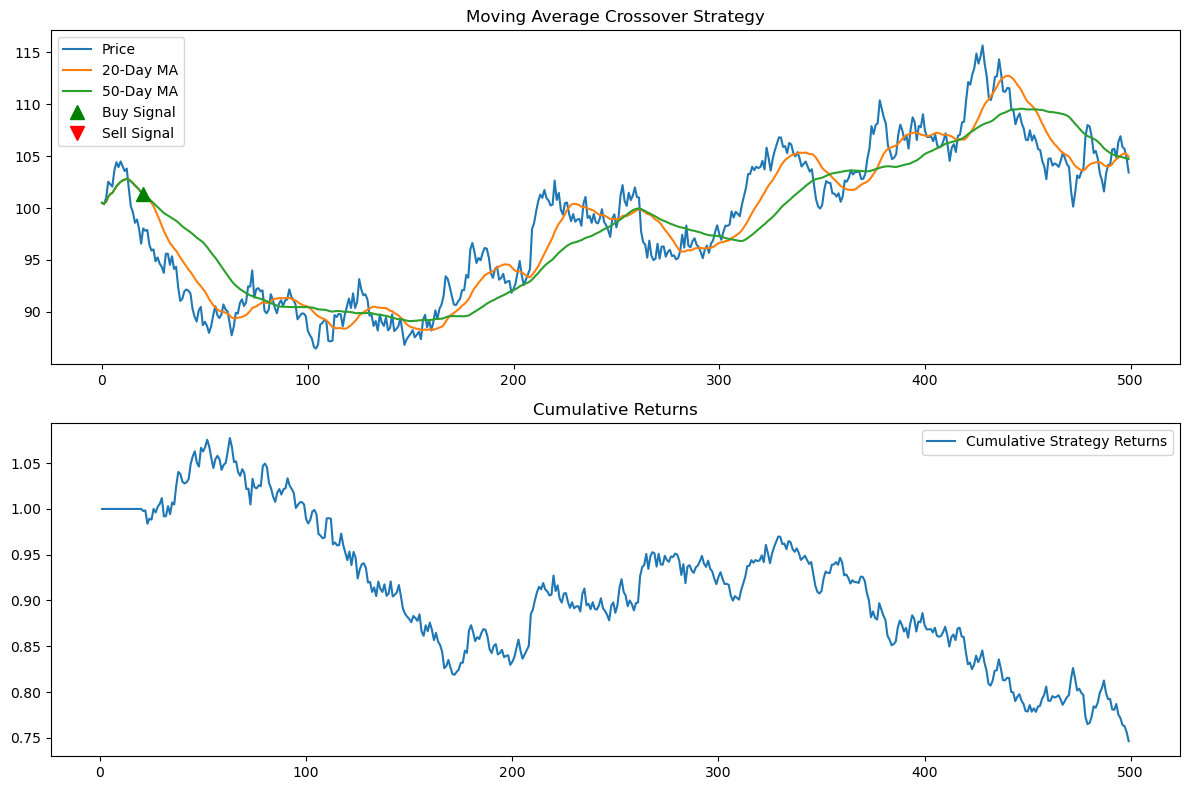

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Generate Sample Data
np.random.seed(42)
data = np.random.randn(500).cumsum() + 100
df = pd.DataFrame({'price': data})

# 2. Strategy Implementation
short_window = 20
long_window = 50

df['short_mavg'] = df['price'].rolling(window=short_window, min_periods=1).mean()
df['long_mavg'] = df['price'].rolling(window=long_window, min_periods=1).mean()

# Generate signals
df['signal'] = 0
df['signal'][short_window:] = np.where(df['short_mavg'][short_window:] > df['long_mavg'][short_window:], 1, -1)

# Create positions
df['positions'] = df['signal'].diff()

# 3. Backtesting
df['returns'] = df['price'].pct_change()
df['strategy_returns'] = df['returns'] * df['signal'].shift(1)

# 4. Performance Analysis
cumulative_returns = (1 + df['strategy_returns']).cumprod()
sharpe_ratio = df['strategy_returns'].mean() / df['strategy_returns'].std() * np.sqrt(252) # Annualized

print(f"Annualized Sharpe Ratio: {sharpe_ratio:.2f}")

# Plotting
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(df['price'], label='Price')
plt.plot(df['short_mavg'], label=f'{short_window}-Day MA')
plt.plot(df['long_mavg'], label=f'{long_window}-Day MA')
plt.plot(df[df['positions'] == 1].index, df['short_mavg'][df['positions'] == 1], '^', markersize=10, color='g', label='Buy Signal')
plt.plot(df[df['positions'] == -1].index, df['short_mavg'][df['positions'] == -1], 'v', markersize=10, color='r', label='Sell Signal')
plt.title('Moving Average Crossover Strategy')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(cumulative_returns, label='Cumulative Strategy Returns')
plt.title('Cumulative Returns')
plt.legend()

plt.tight_layout()
plt.show()

## 2. Advanced Backtesting Frameworks: Event-Driven, Vectorized, and Hybrid Approaches

Backtesting methods vary from event-based simulations to vectorized computations, each with trade-offs in speed and realism. Hybrid techniques balance efficiency and accuracy.

- Vectorized Backtesting: This approach is the simplest and fastest. It uses matrix and vector operations to apply trading rules to the entire dataset at once. However, it's less flexible and can be prone to look-ahead bias if not implemented carefully. The example above is a vectorized backtest.
- Event-Driven Backtesting: This approach simulates the trading process tick-by-tick or bar-by-bar, processing market data as it arrives. It's more realistic as it can model time-dependent logic, transaction costs, and market impact. However, it is slower and more complex to build.
- Hybrid Approaches: These combine the speed of vectorized backtesting with the realism of event-driven backtesting. For example, a strategy's signals might be generated using a vectorized approach, while the order execution and portfolio management are handled by an event-driven system.

In [6]:
import queue
import time
import pandas as pd
import numpy as np

class Event:
    pass

class MarketEvent(Event):
    def __init__(self):
        self.type = 'MARKET'

class SignalEvent(Event):
    def __init__(self, symbol, datetime, signal_type):
        self.type = 'SIGNAL'
        self.symbol = symbol
        self.datetime = datetime
        self.signal_type = signal_type # 'LONG', 'SHORT', 'EXIT'

class OrderEvent(Event):
    def __init__(self, symbol, order_type, quantity, direction):
        self.type = 'ORDER'
        self.symbol = symbol
        self.order_type = order_type # 'MKT' or 'LMT'
        self.quantity = quantity
        self.direction = direction # 'BUY' or 'SELL'

class FillEvent(Event):
    def __init__(self, timeindex, symbol, exchange, quantity, direction, fill_cost, commission=0.0):
        self.type = 'FILL'
        self.timeindex = timeindex
        self.symbol = symbol
        self.exchange = exchange
        self.quantity = quantity
        self.direction = direction
        self.fill_cost = fill_cost
        self.commission = commission


class Backtester:
    def __init__(self, data):
        self.events = queue.Queue()
        self.data_handler = data # This would be a class that provides market data
        self.continue_backtest = True

    def _run_backtest(self):
        """
        Executes the backtest.
        """
        while True:
            # Update the market data
            if self.data_handler.continue_backtest:
                self.data_handler.update_bars()
            else:
                break

            # Handle the events
            while True:
                try:
                    event = self.events.get(False)
                except queue.Empty:
                    break
                else:
                    if event is not None:
                        if event.type == 'MARKET':
                            # Handle MarketEvent
                            # Generate signals from strategy object
                            # And put SignalEvent to the queue
                            pass
                        elif event.type == 'SIGNAL':
                            # Handle SignalEvent
                            # Generate OrderEvent from portfolio object
                            pass
                        elif event.type == 'ORDER':
                            # Handle OrderEvent
                            # Send order to execution handler
                            pass
                        elif event.type == 'FILL':
                            # Handle FillEvent
                            # Update portfolio
                            pass
            time.sleep(1) # Simulate time passing

    def simulate_trading(self):
        self._run_backtest()

# This is a simplified, conceptual example. A full implementation would require
# classes for Strategy, Portfolio, ExecutionHandling, etc.


## 3. Walk-Forward Analysis and Out-of-Sample Testing Protocols

Walk-forward analysis is a more robust method of backtesting that helps to avoid overfitting and provides a more realistic estimate of a strategy's future performance. It involves optimizing a strategy's parameters on a training set of data and then testing it on a subsequent, unseen "out-of-sample" dataset. This process is repeated by moving the training and testing windows forward in time.

In [7]:
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Sample data
X = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12]])
y = np.array([1, 2, 3, 4, 5, 6])

# Initialize TimeSeriesSplit for walk-forward validation
# We are creating 3 splits
tscv = TimeSeriesSplit(n_splits=3)

print("Walk-Forward Analysis Splits:")
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # In a real scenario, you would:
    # 1. Train your model on X_train, y_train
    # 2. Test your model on X_test, y_test
    # 3. Store the performance results
    # 4. Repeat for the next split


Walk-Forward Analysis Splits:
TRAIN: [0 1 2] TEST: [3]
TRAIN: [0 1 2 3] TEST: [4]
TRAIN: [0 1 2 3 4] TEST: [5]


## 4. Common Backtesting Pitfalls: Survivorship Bias, Look-Ahead Bias, Data Mining

- Survivorship Bias: This occurs when backtesting is performed on a dataset that only includes "surviving" assets (e.g., stocks that were not delisted). This can lead to overly optimistic results.
- Look-Ahead Bias: This happens when the trading model uses information that would not have been available at the time of the trade. For example, using the closing price of a day to make a trading decision at the beginning of the day.
- Data Mining (or Overfitting): This occurs when a strategy is overly tailored to fit the historical data, including its noise. Such a strategy is unlikely to perform well on new data.


In [2]:
import pandas as pd
import numpy as np

# Generate sample price data
data = {'price': np.random.rand(100) * 10 + 100}
df = pd.DataFrame(data)

# Incorrectly using future information
# This code uses the daily high and low to make a decision,
# but in a real scenario, you wouldn't know the high and low until the day is over.
df['high'] = df['price'] + np.random.rand(100)
df['low'] = df['price'] - np.random.rand(100)
df['signal'] = np.where(df['price'] > (df['high'].shift(-1) + df['low'].shift(-1)) / 2, -1, 1)

# This is a flawed backtest because df['high'].shift(-1) and df['low'].shift(-1)
# use information from the next day to generate a signal for the current day.

## 5. Stress Testing: Market Crash Scenarios, Regime Changes, Liquidity Crises

Stress testing involves evaluating a strategy's performance under extreme, but plausible, market conditions. This helps to understand the potential risks and drawdowns of the strategy. Examples of stress tests include:

- Simulating a market crash (e.g., the 2008 financial crisis).
- Testing the strategy in different market regimes (e.g., high vs. low volatility).
- Simulating a liquidity crisis where it becomes difficult to execute trades.

## 6. Paper Trading and Pre-Production Validation

Paper trading is the final step before deploying a strategy with real money. It involves running the strategy in a simulated environment with live market data but without actual capital at risk. This helps to:

- Verify that the strategy behaves as expected in a live environment.
- Test the integration with the broker's execution system.
- Identify any issues with data feeds, software bugs, or latency.

In [3]:
class PaperTrader:
    def __init__(self, strategy, broker_api):
        self.strategy = strategy
        self.broker_api = broker_api
        self.positions = {}

    def run(self):
        while True:
            market_data = self.broker_api.get_market_data()
            signal = self.strategy.generate_signal(market_data)

            if signal == 'BUY':
                self.broker_api.submit_order('BUY', 100)
                print("Paper trading: BUY signal executed")
            elif signal == 'SELL':
                self.broker_api.submit_order('SELL', 100)
                print("Paper trading: SELL signal executed")

            # Sleep for a while before the next iteration
            time.sleep(60)


## 7. Execution Systems Integration: TWAP, VWAP, Implementation Shortfall, Adaptive Algorithms

- TWAP (Time-Weighted Average Price): This algorithm breaks down a large order into smaller pieces and executes them at regular intervals over a specified time period. The goal is to execute the order at a price close to the average price during that period.
- VWAP (Volume-Weighted Average Price): Similar to TWAP, but the order execution is weighted by the trading volume. The goal is to execute the order at a price close to the volume-weighted average price.
- Implementation Shortfall: This is the difference between the price at which a trade was decided upon and the final execution price. Execution algorithms aim to minimize this shortfall.
- Adaptive Algorithms: These are more sophisticated algorithms that dynamically adjust their trading strategy based on real-time market conditions, such as volatility and liquidity.


In [8]:
import pandas as pd
import numpy as np

def vwap_execution(df, total_quantity, start_time, end_time):
    """
    Executes a trade to match the VWAP profile of the market.

    df: DataFrame with 'datetime', 'price', and 'volume'
    total_quantity: The total number of shares to trade
    start_time, end_time: The time window for execution
    """
    trade_schedule = []
    
    # Filter for the trading window
    execution_df = df[(df['datetime'] >= start_time) & (df['datetime'] <= end_time)]
    
    # Calculate total volume in the window
    total_market_volume = execution_df['volume'].sum()
    
    # Calculate the proportion of volume for each bar
    execution_df['volume_proportion'] = execution_df['volume'] / total_market_volume
    
    # Determine the number of shares to trade in each bar
    execution_df['trade_quantity'] = (execution_df['volume_proportion'] * total_quantity).round().astype(int)
    
    # Create a trade schedule
    for index, row in execution_df.iterrows():
        if row['trade_quantity'] > 0:
            trade_schedule.append({
                'time': row['datetime'],
                'quantity': row['trade_quantity'],
                'price': row['price'] # In reality, you'd execute at the market price
            })
            
    return trade_schedule

# Sample Data
# In a real scenario, this data would be streaming in
df = pd.DataFrame({
    'datetime': pd.to_datetime(['2025-09-26 09:30', '2025-09-26 09:31', '2025-09-26 09:32', '2025-09-26 09:33']),
    'price': [100.1, 100.2, 100.15, 100.25],
    'volume': [10000, 12000, 8000, 15000]
})

# Execute an order for 1000 shares over the first 3 minutes
schedule = vwap_execution(df, 1000, '2025-09-26 09:30', '2025-09-26 09:32')

print("VWAP Trade Schedule:")
for trade in schedule:
    print(trade)


VWAP Trade Schedule:
{'time': Timestamp('2025-09-26 09:30:00'), 'quantity': 333, 'price': 100.1}
{'time': Timestamp('2025-09-26 09:31:00'), 'quantity': 400, 'price': 100.2}
{'time': Timestamp('2025-09-26 09:32:00'), 'quantity': 267, 'price': 100.15}


/var/folders/98/pgyvqp115_q7lctf5vvv65gr0000gp/T/ipykernel_59721/3097388940.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  execution_df['volume_proportion'] = execution_df['volume'] / total_market_volume
/var/folders/98/pgyvqp115_q7lctf5vvv65gr0000gp/T/ipykernel_59721/3097388940.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  execution_df['trade_quantity'] = (execution_df['volume_proportion'] * total_quantity).round().astype(int)


## 8. Market Impact Models, Transaction Cost Analysis, and Slippage Optimization

- Market Impact: This is the effect that a trade has on the price of an asset. Large trades can move the market, leading to an unfavorable execution price. Market impact models aim to estimate this effect.
- Transaction Cost Analysis (TCA): This is the process of measuring the total costs of trading, including commissions, fees, and market impact.
- Slippage: This is the difference between the expected price of a trade and the price at which the trade is actually executed. Slippage can be caused by market volatility or low liquidity.

## 9. Building on Chapter 3-6 Concepts for Comprehensive Strategy Evaluation and Execution

This section emphasizes the importance of integrating the concepts from the previous chapters to build a complete and robust trading system. This includes:

- Feature Engineering (Chapter 3): Creating informative features from raw data to improve the performance of machine learning models.
- Quantitative Finance (Chapter 4): Using mathematical models to price assets and manage risk.
- Deep Learning and NLP (Chapter 5): Using advanced AI techniques to extract insights from large and unstructured datasets.
- Reinforcement Learning (Chapter 6): Training autonomous agents to make optimal trading decisions.

# Summary

Chapter 7 equips readers with advanced strategy development techniques, rigorous backtesting methods, execution optimization, and holistic system integration approaches necessary for robust AI trading system deployment.